In [1]:
import os
import pandas as pd
import io
import matplotlib.pyplot as plt

start_date = pd.to_datetime("2024-04-01")

In [2]:
from math import floor, log10


def round_to_2(x):
    return round(x, -int(floor(log10(abs(x)))) + 1)


def plt_progress(df, unit):
    idx = pd.date_range(df.index[0], df.index[-1])
    # calc before reindexing
    pace_for_cutoff = 2 * df["count"].diff()[-21:].mean()
    df = df.reindex(idx, method="pad")
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    smoothed = df["count"].diff().rolling(window=7).mean()
    weekly_pace = smoothed.dropna()[-1]
    todays_pace = df["count"].diff().iloc[-1]
    best_pace = smoothed.abs().max()

    axs[0].set_title(
        f"today ({todays_pace}) weekly avg.({round_to_2(weekly_pace)}) best weekly avg. ({round_to_2(smoothed.max())}) {unit}/day"
    )
    axs[0].bar(df.index, df["count"].diff(), width=1)
    # axs[0].plot(min_day + pd.to_timedelta(smoothed[:,0], "days"), smoothed[:,1], color="red")
    axs[0].plot(df.index, smoothed, color="red", lw=2)
    axs[0].set_xlabel("")
    axs[0].set_ylabel("new")
    axs[0].set_ylim(0, pace_for_cutoff * 2)

    df.plot(drawstyle="steps-post", legend=False, ax=axs[1])
    axs[1].set_title(f"Currently at {df['count'].iloc[-1]:.0f} {unit}")
    axs[1].set_xlabel("")
    axs[1].set_ylabel("total")
    axs[1].set_ylim(0, None)

    for ax in axs:
        ax.set_xlim(start_date, None)

    fig.autofmt_xdate()
    plt.show()

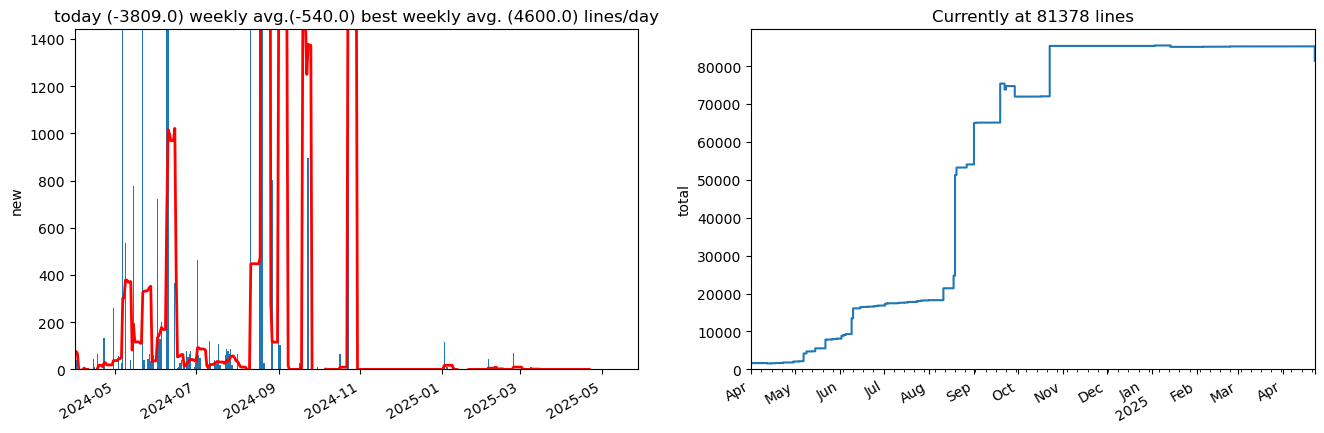

In [3]:
command = os.popen("echo 'date,lines,empty';/Users/stefan/bin/gitdatalines '*.tex'")

lines = pd.read_csv(io.StringIO(command.read()), sep=",")[["date", "lines"]]
lines["date"] = pd.to_datetime(lines["date"])
tlines = lines.groupby("date").sum()
tlines["count"] = tlines["lines"].cumsum()
tlines = tlines[["count"]]

plt_progress(tlines, "lines")

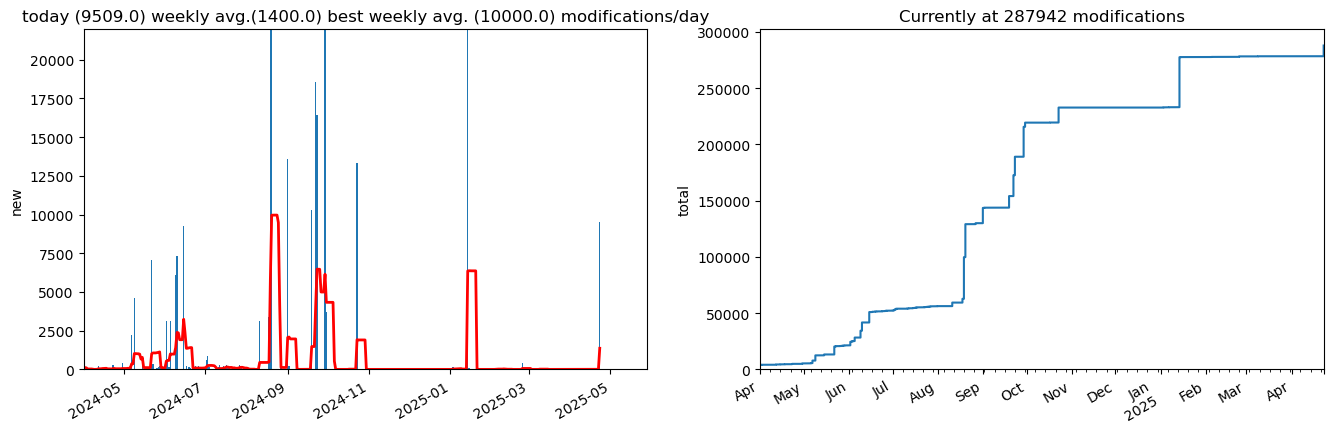

In [4]:
command = os.popen(
    "echo 'date modifications';/Users/stefan/bin/gitdatamodifications '*.tex'"
)
modifications = pd.read_csv(io.StringIO(command.read()), sep=" ")[
    ["date", "modifications"]
]
modifications["date"] = pd.to_datetime(modifications["date"])
tmodifications = modifications.groupby("date").sum()

tmodifications["count"] = tmodifications["modifications"].cumsum()
tmodifications = tmodifications[["count"]]

plt_progress(tmodifications, "modifications")

/var/folders/9y/xdxkkt710kx5tf1j0p68y46r0000gn/T/ipykernel_22719/261944244.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  twdiffs = wdiffs.groupby("date").sum()


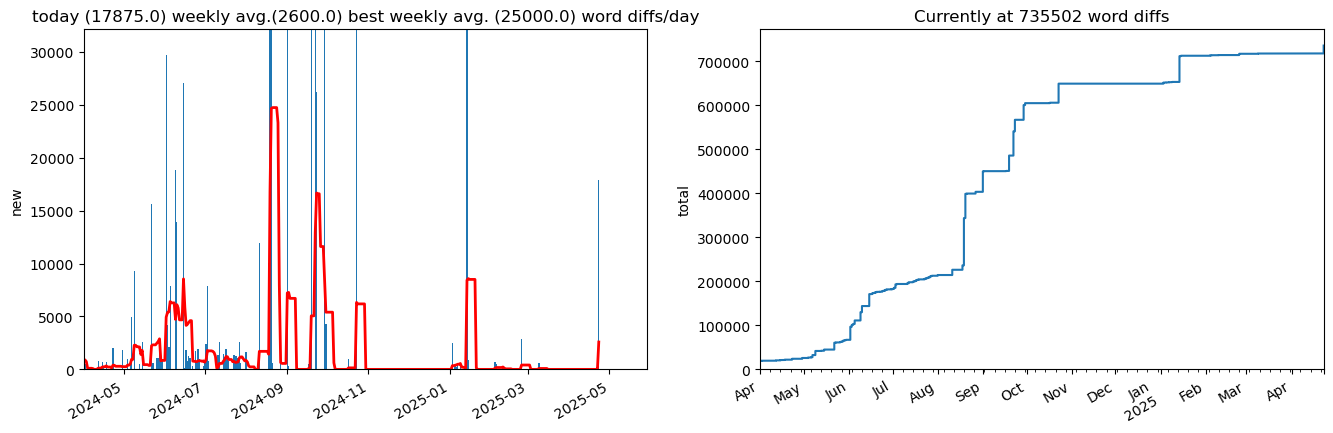

In [5]:
command = os.popen("/Users/stefan/bin/gitdataworddiffs")

wdiffs = pd.read_csv(io.StringIO(command.read()), sep=",")
wdiffs["date"] = pd.to_datetime(wdiffs["date"])
twdiffs = wdiffs.groupby("date").sum()

twdiffs["count"] = twdiffs["wdiffs"].cumsum()
twdiffs = twdiffs[["count"]]

plt_progress(twdiffs, "word diffs")

In [7]:
command = os.popen("cd ../thesis_progress && ./progress.sh")
_ = io.StringIO(command.read())

word_count = pd.read_csv("../thesis_progress/progress.csv")
word_count.dropna(inplace=True)
word_count["date"] = pd.to_datetime(word_count["date"])

Error: Invalid PDF: Rebuild failed: trailer not found.; Original message: PDF startxref not found.
Error: Failed to open input PDF file: 
   thesis.pdf
Done.  Input errors, so no output created.
Previous HEAD position was 6fe8e5a Add LICENCE
Switched to branch 'thesis_progress'


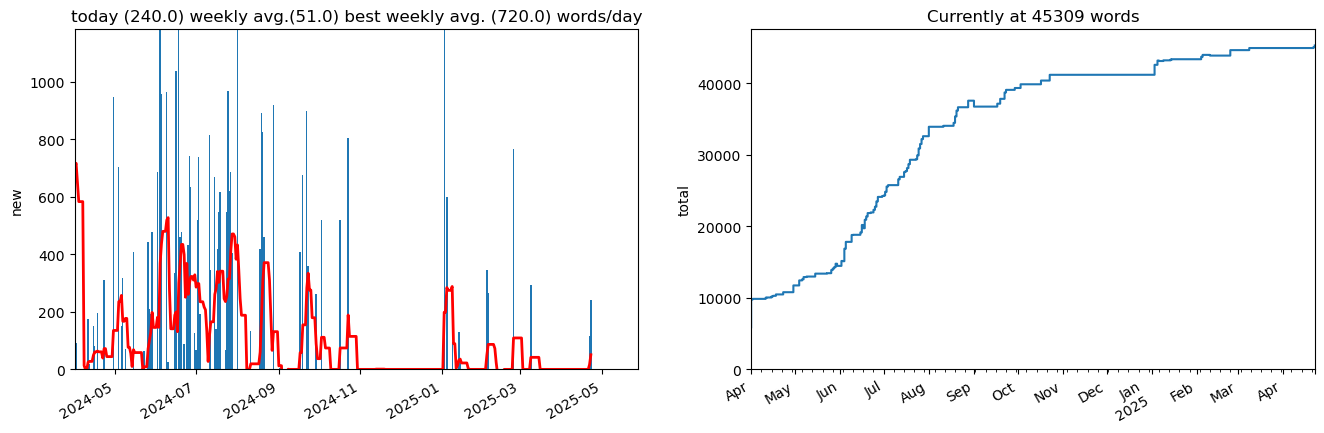

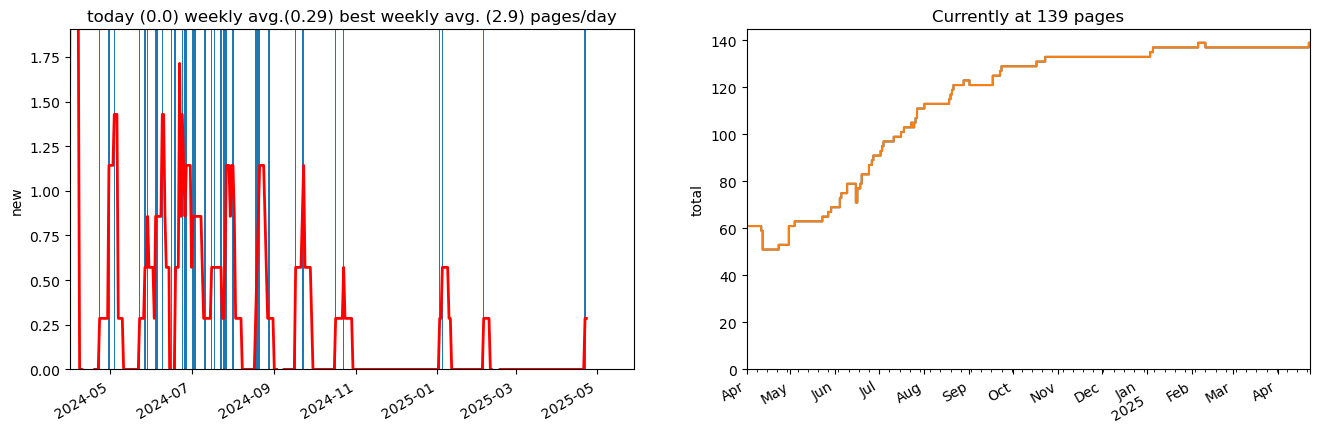

In [8]:
tword_count = word_count.groupby("date").last()

df_words = tword_count[["count"]]
plt_progress(df_words, "words")
df_pages = tword_count[["pages"]].copy()
df_pages["count"] = df_pages["pages"]
plt_progress(df_pages, "pages")